In [1]:
!jt -t grade3 -tf merriserif -tfs 16 -nf ptsans -nfs 9
# !jt -r

/bin/bash: jt: command not found


# A visual guide to ScanDy

The purpose of this notebook is to give you some intuition about how ScanDy works. We will guide you through the different components / modules of the framework and visualize what different parameters do in the current implementation of the default models. Importantly, we do not always use the actual functions from the models but use reimplementations that make visualization easier. If you go through this notebook, it'll be a breeze to go through and understand the actual implementations of the models in the `scandy/models` folder.

For detailed descriptions of the different modules, please refer to the [manuscript](https://www.biorxiv.org/content/10.1101/2023.03.14.532608v1.full.pdf).

In [2]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
print(os.getcwd())

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import flow_vis
import ipywidgets as ipyw

from scandy.models.ObjectModel import ObjectModel
from scandy.models.LocationModel import LocationModel
from scandy.utils.dataclass import Dataset
import scandy.utils.functions as uf

/beegfs/home/users/n/nicolas-roth/ScanDy


## Load the *VidCom* dataset
This dataset was published in Li et al. (2011) and the eye tracking data and videos are available here: http://ilab.usc.edu/vagba/dataset/VidCom/

In [3]:
datadict = {
    "PATH": "/scratch/nroth/VidCom/VidCom/", # HPC
    'FPS' : 30,
    'PX_TO_DVA' : 0.06,
    'FRAMES_ALL_VIDS' : 300,
    'gt_foveation_df' : '2021-12-04_VidCom_GT_fov_df',
    'gt_fovframes_nss_df' : 'gt_fovframes_nss_df.csv',
    'trainset' : ['field03'], #sorted(['dance02', 'park01', 'park06', 'road04', 'road05', 'room01', 'room02', 'walkway03', 'dance01', 'field03', 'foutain02', 'garden04', 'garden06', 'garden07', 'garden09', 'park09', 'road02', 'robarm01', 'room03', 'tommy02', 'uscdog01', 'walkway01', 'walkway02']),
    'testset' : [],
}
VidCom = Dataset(datadict)

With the dataset ready, we'll now go through the different modules of the framework., which are shown in the figures below for the object-based and location-based model families.

* Location-based

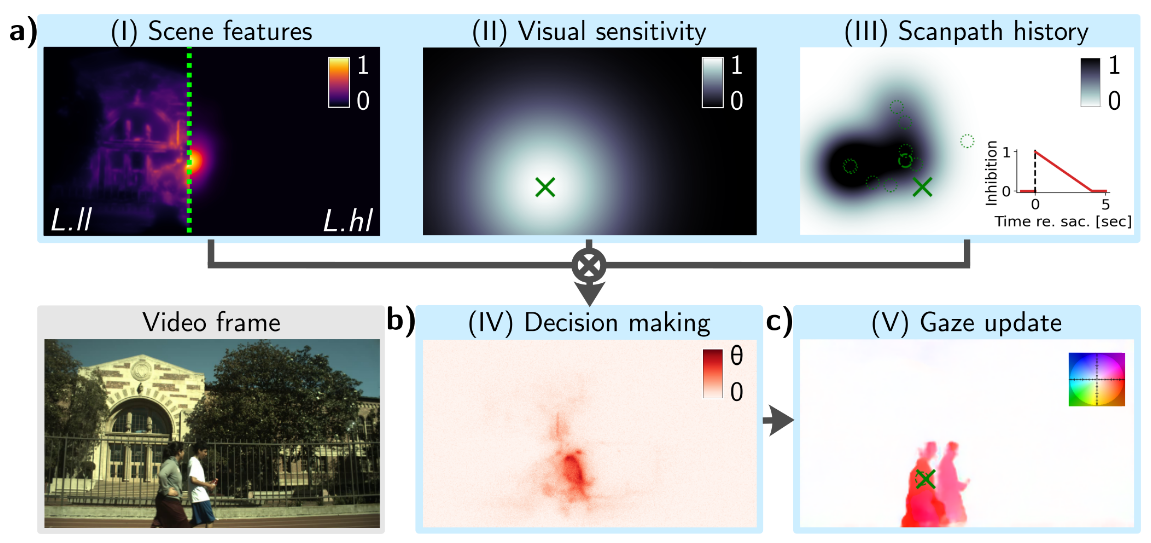

* Object-based

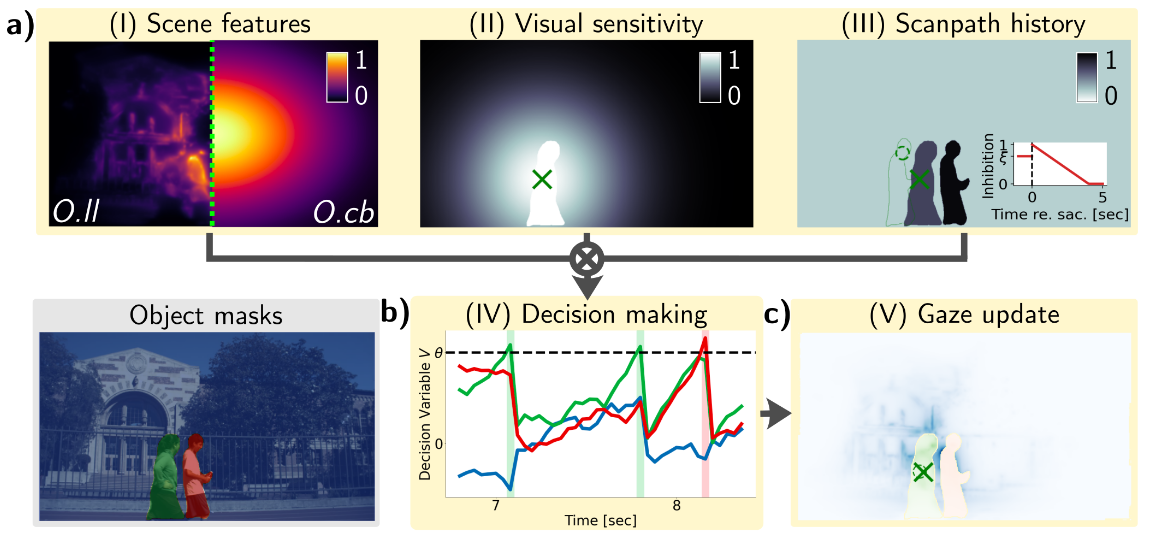


We'll start with

## (I) Scene features


### Access (precomputed) data 

* Low-level features: https://github.com/csmslab/dynamic-proto-object-saliency

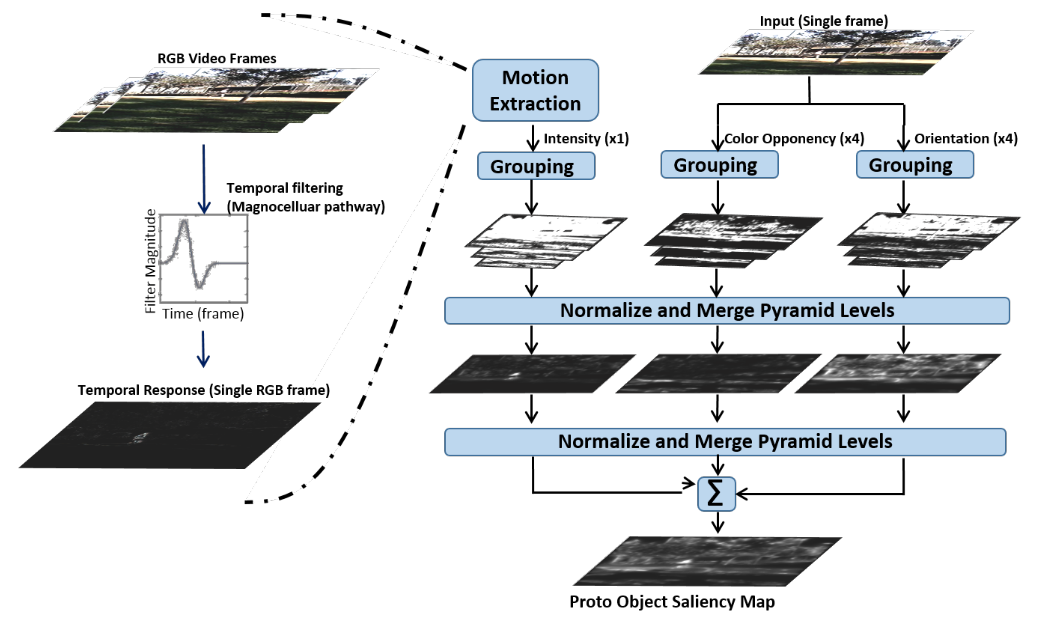

* High-level features: https://github.com/MichiganCOG/TASED-Net

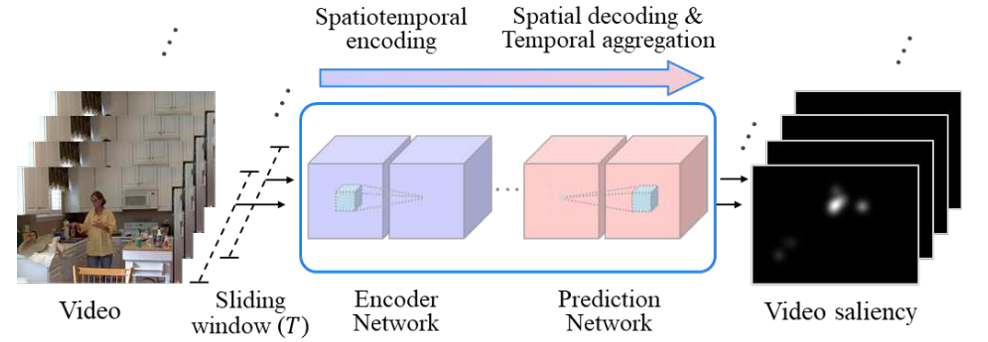

Other pre-computed maps from the dataset we'll load later:
* Object masks
    * Segmentation: https://github.com/facebookresearch/detectron2
    * Tracking: https://github.com/nwojke/deep_sort
* Optical flow https://github.com/NVlabs/PWC-Net 

The Dataclass allows easy access to the precomputed maps. In the following, we will use the `field03` video of the VidCom dataset as example for visualizing the model components.

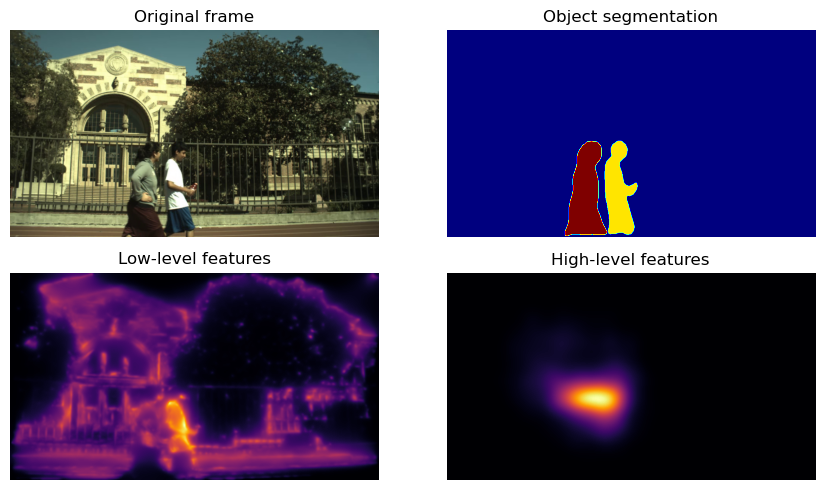

In [4]:
video = 'field03'
frame = 230

vidframe = VidCom.load_videoframes(video)[frame]
objects = VidCom.load_objectmasks(video)[frame]
low_level_features = VidCom.load_featuremaps(video, 'molin', centerbias=None)[frame]
high_level_features = VidCom.load_featuremaps(video, 'TASEDnet', centerbias=None)[frame]

fig, axs = plt.subplots(2,2, figsize=(9,5), dpi=100)
axs[0,0].imshow(vidframe); axs[0,0].set(title='Original frame')
axs[0,1].imshow(objects, cmap='jet'); axs[0,1].set(title='Object segmentation')
axs[1,0].imshow(low_level_features, cmap='inferno'); axs[1,0].set(title='Low-level features')
axs[1,1].imshow(high_level_features, cmap='inferno'); axs[1,1].set(title='High-level features')
[axi.set_axis_off() for axi in axs.ravel()]
fig.tight_layout(); plt.show()

In addition to the already shown precomputed saliency maps, we can explicitely account for the central viewing bias, which is by default implemented as anisotropic Gaussian with parameters from Clarke & Tatler (2014). 

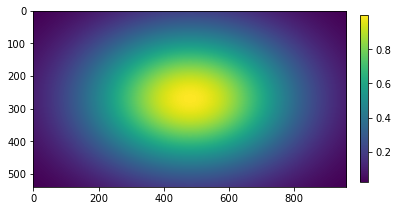

In [5]:
cb = uf.anisotropic_centerbias(VidCom.VID_SIZE_X, VidCom.VID_SIZE_Y)
im = plt.imshow(cb); plt.colorbar(im,fraction=0.025, pad=0.04); plt.show()

We can directly load the saliency maps with the center bias applied:

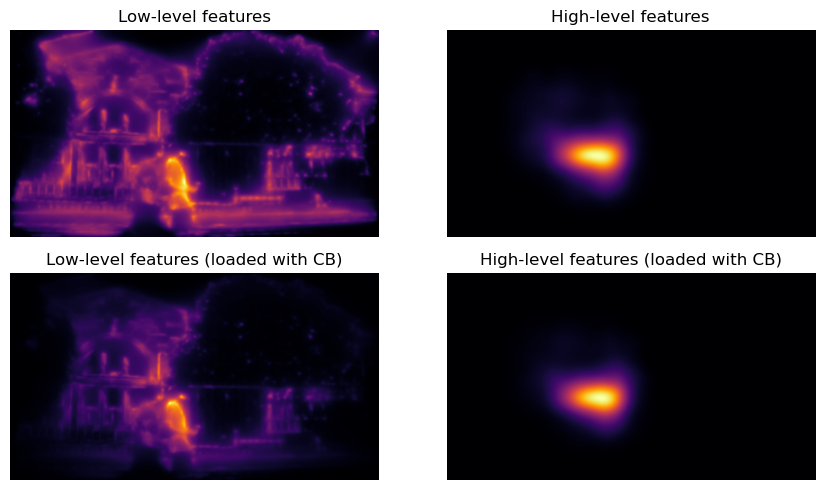

In [6]:
fig, axs = plt.subplots(2,2, figsize=(9,5), dpi=100)
plt.set_cmap('inferno')
axs[0,0].imshow(low_level_features); axs[0,0].set(title='Low-level features')
axs[0,1].imshow(high_level_features); axs[0,1].set(title='High-level features')

low_level_features_with_cb = VidCom.load_featuremaps(video, 'molin', centerbias='anisotropic_default')[frame]
high_level_features_with_cb = VidCom.load_featuremaps(video, 'TASEDnet', centerbias='anisotropic_default')[frame]

axs[1,0].imshow(low_level_features_with_cb); axs[1,0].set(title='Low-level features (loaded with CB)')
axs[1,1].imshow(high_level_features_with_cb); axs[1,1].set(title='High-level features (loaded with CB)')
[axi.set_axis_off() for axi in axs.ravel()]
fig.tight_layout(); plt.show()

## (II) Visual sensitivity
Secondly, we model how sensitive we are to the visual information in the scene, depending on the current gaze position.

In our very crude approximation of implementing object-based attention, we just assume that the visual sensitivity spreads evenly across the currently foveated object mask.

In [7]:
def sensitivity(OBA, att_dva, gazeloc_x):
    gaze_loc = [400, int(gazeloc_x)] # yval, xval (numpy is very confusing here...)
    # simple Gaussian (variable size)
    S = uf.gaussian_2d(gaze_loc[1], gaze_loc[0], VidCom.VID_SIZE_X, VidCom.VID_SIZE_Y, 
                       att_dva * VidCom.DVA_TO_PX)
    if OBA:  # object-based attention
        obj_id = objects[gaze_loc[0], gaze_loc[1]]
        if obj_id > 0:
            S[objects==obj_id] = 1.
    plt.figure(figsize=(12,6))
    im = plt.imshow(S, cmap='bone', vmax=1, vmin=0)
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.axis('off')
    plt.scatter(gaze_loc[1], gaze_loc[0], marker='x', s=1000, c='green', lw=5)
    plt.show()

ipyw.interactive(sensitivity, 
                 OBA=[False, True],
                 gazeloc_x=ipyw.FloatSlider(value=350., min=200, max=500, step=50),
                 att_dva=ipyw.FloatSlider(value=10., min=1, max=20, step=1))
   

interactive(children=(Dropdown(description='OBA', options=(False, True), value=False), FloatSlider(value=10.0,…

## (III) Scanpath history

While (II) took into account where we currently look, the third module consideres the scanpath history. Instead of attempting to implement a complete model of visual working memory, we just go with the classic inhibition of return. This can be either based on previously observed (pixel) locations or on the previously observed objects.

To demonstrate this, we take an example from the ground truth scanpaths by filtering for one subject watching the example video...

Our data consists only of foveation (i.e. fixation & smooth pursuit) events, information about the saccades between these events are included in the dataframe. 

In [8]:
frame = 230
# use the data from one human subject for the example video
sp_history = VidCom.gt_foveation_df[(VidCom.gt_foveation_df.video==video) & (VidCom.gt_foveation_df.subject=='SN')]
# only up to our example frame
sp_history = sp_history[sp_history.frame_start<=frame]
sp_history

,duration_ms,x_start,x_end,y_start,y_end,frame_start,frame_end,subject,video,object,sac_amp_dva,sac_angle_h,sac_angle_p,fov_category,ret_times,nfov
373,270.833,480,484,270,276,0,8,SN,field03,Ground,NaN,NaN,NaN,B,NaN,0
374,83.333,333,332,337,335,11,13,SN,field03,Ground,9.692925,155.497341,NaN,B,NaN,1
375,616.666,259,222,397,396,15,34,SN,field03,Object 1,5.716083,140.964487,-14.532853,D,NaN,2
376,2029.166,208,121,389,399,41,101,SN,field03,Object 1,3.097418,-171.085073,47.950440,I,NaN,3
377,183.334,303,307,298,297,114,120,SN,field03,Ground,7.893136,-43.768023,127.317050,B,NaN,4
378,45.834,301,302,216,217,137,139,SN,field03,Ground,4.921463,-91.397181,-47.629158,B,NaN,5
379,129.167,277,267,172,167,147,151,SN,field03,Ground,3.007191,-118.610460,-27.213279,B,NaN,6
380,216.667,142,177,340,339,190,197,SN,field03,Object 2,12.931218,128.784364,-112.605176,D,NaN,7
381,412.500,145,244,344,336,198,210,SN,field03,Object 3,0.300000,53.130102,-75.654262,D,NaN,8
382,479.167,302,416,326,319,212,226,SN,field03,Object 2,9.481709,-6.540386,-59.670488,R,500.000000,9


### Location-based IOR
*ScanDy* side note: In practice, this is updated, not calculated anew for each frame.

$    I(x,y,t) = \min\left(1, \sum_{h=1}^{N_F} \max\left(0, \left( 1 - r \cdot (t-t_h)\right)  G_I(x,y)^{(h)}\right)\right),
$

In [9]:
gaze_loc = [400, 350]
assert frame == 230, f"Frame was changed to {frame} in previous cell, should be 230!"

def inhibition(ior_dva, ior_decay, show_prev_target):
    r = 1/ior_decay
    # fig1 showing linear decrease of IOR
    fig, ax = plt.subplots(figsize=(6,3))
    ax.plot([-1,0], [0,0], color='tab:red', lw=10)
    x = np.linspace(0,5,100)
    y = np.maximum(0, 1 - r * (VidCom.FPS * x)) 
    ax.plot(x, y, color='tab:red', lw=10)
    ax.axvline(0, ls='--', color='k', lw=7)
    fs=30; ax.set_ylabel(r'Inhibition', fontsize=fs)
    ax.set_xlabel('Relative time [sec]', fontsize=fs)
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.set(yticks=[0, 1], yticklabels=['0', '1'])
    ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
    plt.show()
    # fig2 showing location-based inhibition
    IOR_maps = []
    for s, sac_time in enumerate(sp_history.frame_start[:-1]):
        # discount inhibition with time 
        weight = 1-r*(frame - sac_time)
        if weight >0:
            # draw a Gaussian around every past target location that is "not yet forgotten"
            ior_map = weight * uf.gaussian_2d(sp_history.x_start.iloc[s], sp_history.y_start.iloc[s],
                                              VidCom.VID_SIZE_X, VidCom.VID_SIZE_Y,
                                              ior_dva * VidCom.DVA_TO_PX)
            IOR_maps.append(ior_map)
    I = np.clip(np.sum(IOR_maps, axis=0), 0, 1)
    
    plt.figure(figsize=(12,6))
    im = plt.imshow(1 - I, vmin=0, vmax=1, cmap='bone')
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.scatter(gaze_loc[1], gaze_loc[0], marker='x', s=1000, c='green', lw=5)
    if show_prev_target == "All":
        for s, sac_time in enumerate(sp_history.frame_start[:-1]):
            plt.scatter(sp_history.x_start.iloc[s], sp_history.y_start.iloc[s], s=500, facecolors='none', 
                    edgecolors='green', linestyle=':', linewidth=2)
    if show_prev_target != "No":  
        plt.scatter(sp_history.x_start.iloc[s], sp_history.y_start.iloc[s], s=500, facecolors='none', 
                    edgecolors='green', linestyle='--', linewidth=3)
    plt.axis('off'); plt.show()
    
ipyw.interactive(inhibition, 
                 show_prev_target= ["No", "Yes", "All"],
                 ior_decay=ipyw.FloatSlider(value=120., min=30, max=300, step=30),
                 ior_dva=ipyw.FloatSlider(value=4., min=1., max=15.0, step=1.))


interactive(children=(FloatSlider(value=4.0, description='ior_dva', max=15.0, min=1.0, step=1.0), FloatSlider(…

### Object-based IOR
(in the actual model, this is updated, not calculated anew for each frame)

$    I_i(t) = 
    \begin{cases}
        \xi,                            & \text{if } (x_0,y_0) \in O_i\\
        \max\left(0, 1 - r \cdot (t-t_h)\right),    & \text{else.}
    \end{cases}
$

In [10]:
gaze_loc = [400, 350]
assert frame == 230, f"Frame was changed to {frame} in previous cell, should be 230!"

def inhibition(xi, ior_decay, show_prev_target):
    r = 1/ior_decay
    # fig1 showing linear decrease of IOR
    fig, ax = plt.subplots(figsize=(6,3))
    ax.plot([-1,0], [xi,xi], color='tab:red', lw=10)
    x = np.linspace(0,5,100)
    y = np.maximum(0, 1 - r * (VidCom.FPS * x)) 
    ax.plot(x, y, color='tab:red', lw=10)
    ax.axvline(0, ls='--', color='k', lw=7)
    fs=30; ax.set_ylabel(r'Inhibition', fontsize=fs)
    ax.set_xlabel('Relative time [sec]', fontsize=fs)
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.set(yticks=[0, xi, 1], yticklabels=['0', r'$\xi$', '1'])
    ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
    plt.show()
    # fig2 showing object-based inhibition
    I = np.zeros_like(objects, dtype=float)
    for obj_id in np.unique(objects):
        if obj_id == objects[gaze_loc[0], gaze_loc[1]]:
            if obj_id == 0:  # background is not uniformly inhibited
                I[objects==obj_id] = 0
            else:
                I[objects==obj_id] = xi
        else:
            if obj_id == 0:
                last_visited = sp_history[sp_history.object=='Ground'].iloc[-1].frame_end
            else:
                last_visited = sp_history[sp_history.object==f'Object {obj_id}'].iloc[-1].frame_end
            I[objects==obj_id] = max(0, 1-r*(frame - last_visited))
    plt.figure(figsize=(12,6))
    if show_prev_target != "No":
        past_obj = VidCom.load_objectmasks(video)[212]
        plt.contour(past_obj==2, colors='green', linewidths=0.2, linestyles=':') #
        plt.gca().invert_yaxis()
        
    for s, sac_time in enumerate(sp_history.frame_start[:-1]):
        if show_prev_target == "All":
            plt.scatter(sp_history.x_start.iloc[s], sp_history.y_start.iloc[s], s=500, facecolors='none', 
                    edgecolors='green', linestyle=':', linewidth=2)
    if show_prev_target in ["All", "Yes"]:
        plt.scatter(sp_history.x_start.iloc[9], sp_history.y_start.iloc[9], s=500, facecolors='none', 
                    edgecolors='green', linestyle='--', linewidth=3)

    im = plt.imshow(1-I, vmin=0, vmax=1, cmap='bone')
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.scatter(gaze_loc[1], gaze_loc[0], marker='x', s=1000, c='green', lw=5)
    plt.axis('off'); plt.show()
    
ipyw.interactive(inhibition, 
                 show_prev_target= ["No", "Yes", "All"],
                 ior_decay=ipyw.FloatSlider(value=100., min=10, max=310, step=30),
                 xi=ipyw.FloatSlider(value=0.7, min=0., max=1.0, step=0.1),
                )

interactive(children=(FloatSlider(value=0.7, description='xi', max=1.0), FloatSlider(value=100.0, description=…

You might find it a bit surprising, that the person on the right is so strongly inhibited given that the previous saccade targets were on the lefthand side. The reason for that is, that the previous saccade went on right person and it was foveated until a couple of frames before our example frame here (indicated by the green object outline when "show_prev_target" is set to Yes). Tha gaze position just moved with the object, which is not explicitely if only previous saccade targets are shown.

==> Same previous scanpath history, but location-based and object-based IOR lead to very different inhibition patterns!

Now, putting it all together....
## (III) Evidence accumulation for decision making

The results of modules (I-III) are then used to accumulate evidence to move the eyes for each potential saccade target. Targets are either individual pixels (location-based model) or objects (object-based model).

In [11]:
gaze_loc = [400, 350]
assert frame == 230, f"Frame was changed to {frame} in previous cell, should be 230!"

def loc_evidence_obj(features, center_bias, att_dva, xi, ior_decay): #, theta):
    # select feature / saliency map
    if features == 'Low-level':
        if center_bias == 'yes':
            F = low_level_features_with_cb
        else:
            F = low_level_features
    else:
        if center_bias == 'yes':
            F = high_level_features_with_cb
        else:
            F = high_level_features
    # gaussian visual sensitivity incl. object mask
    S = uf.gaussian_2d(gaze_loc[1], gaze_loc[0], VidCom.VID_SIZE_X, VidCom.VID_SIZE_Y, 
                       att_dva * VidCom.DVA_TO_PX)
    obj_id = objects[gaze_loc[0], gaze_loc[1]]
    if obj_id > 0:
        S[objects==obj_id] = 1.
    # inhibition, usually just scalar for each object, here array for plotting...
    r = 1/ior_decay
    I = np.zeros_like(objects, dtype=float)
    for obj_id in np.unique(objects):
        if obj_id == objects[gaze_loc[0], gaze_loc[1]]:
            if obj_id == 0:
                I[objects==obj_id] = 0  # background is not uniformly inhibited
            else:
                I[objects==obj_id] = xi
        else:
            if obj_id == 0:
                last_visited = sp_history[sp_history.object=='Ground'].iloc[-1].frame_end
            else:
                last_visited = sp_history[sp_history.object==f'Object {obj_id}'].iloc[-1].frame_end
            I[objects==obj_id] = max(0, 1-r*(frame - last_visited))
    # plot all together
    fig, axs = plt.subplot_mosaic([["F","S","I"], ["D","D","D"]],figsize=(16,12))
    axs['F'].imshow(F, cmap='inferno'); axs['F'].set_title('Scene features $F$', fontsize=20)
    axs['S'].imshow(S, cmap='bone', vmin=0,vmax=1); axs['S'].set_title('Visual sensitivity $S$', fontsize=20)
    axs['I'].imshow(1-I, cmap='bone', vmin=0,vmax=1); axs['I'].set_title('Scanpath history $(1-I)$', fontsize=20)
    colors = ['Blues', 'Greens', 'Reds']
    mu = F * S * (1 - I)
    maxval = np.max(mu)
    for i, obj_id in enumerate(np.unique(objects)):
        mask = (objects==obj_id); npix = np.sum(mask)
        res = mask * mu 
        print(f'Evidence for object {obj_id} (in {colors[i]}): {round(np.sum(res)*np.log(npix)/npix, 4)}')
        res[res==0] = np.nan
        im = axs['D'].imshow(res, vmin=0, vmax=maxval, cmap=colors[i])
    axs['D'].set_title(r'Combined maps: $F\times S \times (1-I)$', fontsize=30)
    [axs[k].set_axis_off() for k in axs.keys()]
    [axs[k].scatter(gaze_loc[1], gaze_loc[0], marker='x', s=500, c='green', linewidth=3) for k in ['S', 'I', 'D']]
    plt.tight_layout(); plt.show()
    
ipyw.interactive(loc_evidence_obj, 
                 features=['Low-level', 'High-level'],
                 center_bias=['yes', 'no'],
                 att_dva=ipyw.FloatSlider(value=10., min=0.5, max=20.0, step=0.5),
                 ior_decay=ipyw.FloatSlider(value=100., min=10, max=310, step=30),
                 xi=ipyw.FloatSlider(value=0.7, min=0., max=1.0, step=0.1),
                 # theta=ipyw.FloatSlider(value=0.3, min=0.1, max=0.5, step=0.05),
                )

interactive(children=(Dropdown(description='features', options=('Low-level', 'High-level'), value='Low-level')…

$$
        \mu_i(t) = \frac{ \left( \sum_{x,y} O_i(x,y,t) \cdot F(x,y,t) \cdot S(x,y,t) \right)  \cdot (1 - I_i(t)) \cdot  \log\sum_{x,y} O_i(x,y,t)}{\sum_{x,y} O_i(x,y,t)}.
$$

*ScanDy* side note: The combined map corresponds to the landing probability within an object.

### Location-based evidence accumulation

$$
\mu_i(t) = \mu(x,y,t) = F(x,y,t) \cdot S(x,y,t) \cdot (J_{X,Y} - I(x,y,t)),
$$

In [12]:
gaze_loc = [400, 350]
assert frame == 230, f"Frame was changed to {frame} in previous cell, should be 230!"
# preload features
# low_level_features = VidCom.load_featuremaps(video, 'molin', centerbias=None)[frame]
# high_level_features = VidCom.load_featuremaps(video, 'TASEDnet', centerbias=None)[frame]
# low_level_features_with_cb = VidCom.load_featuremaps(video, 'molin', centerbias='anisotropic_default')[frame]
# high_level_features_with_cb = VidCom.load_featuremaps(video, 'TASEDnet', centerbias='anisotropic_default')[frame]


def loc_evidence(features, center_bias, att_dva, ior_dva, ior_decay, ddm_thres, ddm_sig):
    # select feature / saliency map
    if features == 'Low-level':
        if center_bias:
            F = low_level_features_with_cb
        else:
            F = low_level_features
    else:
        if center_bias:
            F = high_level_features_with_cb
        else:
            F = high_level_features
    # gaussian visual sensitivity
    S = uf.gaussian_2d(gaze_loc[1], gaze_loc[0], VidCom.VID_SIZE_X, VidCom.VID_SIZE_Y, 
                       att_dva * VidCom.DVA_TO_PX)
    # decreasing linearly depending how far back the saccade was
    r = 1/ior_decay
    IOR_maps = []
    for s, sac_time in enumerate(sp_history.frame_start[:-1]):
        weight = 1-r*(frame - sac_time)
        if weight >0:
            ior_map = weight * uf.gaussian_2d(sp_history.x_start.iloc[s], sp_history.y_start.iloc[s],
                                              VidCom.VID_SIZE_X, VidCom.VID_SIZE_Y,
                                              ior_dva * VidCom.DVA_TO_PX)
            IOR_maps.append(ior_map)
    I = np.clip(np.sum(IOR_maps, axis=0), 0, 1)
    # plot all together
    fig, axs = plt.subplot_mosaic([["F","S","I"], ["D","D","D"]],figsize=(16,12))
    axs['F'].imshow(F, cmap='inferno'); axs['F'].set_title('Scene features $F$', fontsize=20)
    axs['S'].imshow(S, cmap='bone', vmin=0,vmax=1); axs['S'].set_title('Visual sensitivity $S$', fontsize=20)
    axs['I'].imshow(1-I, cmap='bone', vmin=0,vmax=1); axs['I'].set_title('Scanpath history $(1-I)$', fontsize=20)
    noise = np.random.normal(0, ddm_sig, F.shape)
    im = axs['D'].imshow(F * S * (1 - I) + noise, vmin=0, vmax=ddm_thres, cmap='Reds')
    axs['D'].set_title(r'Combined maps: $F\times S \times (1-I)$', fontsize=30)
    [axs[k].set_axis_off() for k in axs.keys()]
    [axs[k].scatter(gaze_loc[1], gaze_loc[0], marker='x', s=500, c='green', linewidth=3) for k in ['S', 'I', 'D']]
    cbar = plt.colorbar(im, ax=axs['D'], fraction=0.046, pad=0.04, ticks=[0,ddm_thres/3, ddm_thres*2/3, ddm_thres])
    cbar.ax.set_yticklabels(['0', f'{round(ddm_thres/3,2)}', f'{round(2*ddm_thres/3,2)}', r'$\theta$'], size=20) 
    plt.tight_layout(); plt.show()

In [13]:
ipyw.interactive(loc_evidence, 
                 features=['Low-level', 'High-level'],
                 center_bias=[True, False],
                 att_dva=ipyw.FloatSlider(value=10., min=0.5, max=20.0, step=0.5),
                 ior_decay=ipyw.FloatSlider(value=90., min=30, max=300, step=30),
                 ior_dva=ipyw.FloatSlider(value=5., min=1., max=15.0, step=1.),
                 ddm_thres=ipyw.FloatSlider(value=0.3, min=0.1, max=0.5, step=0.05),
                 ddm_sig=ipyw.FloatSlider(value=0.0, min=0.0, max=0.1, step=0.01),
                )

interactive(children=(Dropdown(description='features', options=('Low-level', 'High-level'), value='Low-level')…

$$
    V_i(t+\Delta t) =  V_i(t) + \mu_i(t) \Delta t + s \epsilon \sqrt{\Delta t}, \\ 
    \text{with } \epsilon \sim \mathcal{N}(0,\,1)
$$

This is just a snapshot, showing the evidence that is accumulated for the decision making during one frame.

This evidence is now accumulated until the decision threshold $\theta$ is crossed, which will trigger a saccade, move the gaze position, and start the accumulation process anew.

## (V) Gaze update over time

Run the actual model with a given set of parameters to show how decisions are made.

In [14]:
# Initialize the model
L_ll = LocationModel(VidCom)

# Choose sesible parameters
L_ll.params['ddm_thres'] = 0.4
L_ll.params['ddm_sig'] = 0.01
L_ll.params['att_dva'] = 12.5
L_ll.params['ior_decay'] = 90.
L_ll.params['ior_dva'] = 9.5

# In this case, we just run it for one video and one random seed (simulated subject)
# This will take a few seconds...
L_ll.run('field03', seeds=[42]) # [s for s in range(1,13)]
print(L_ll.result_dict.keys())
print(L_ll.result_dict['field03'].keys())
print(L_ll.result_dict['field03']['seed042'].keys())

dict_keys(['field03'])
dict_keys(['seed042'])
dict_keys(['gaze', 'f_sac'])


In [15]:
res = L_ll.result_dict['field03']['seed042']
low_level_feature_maps = VidCom.load_featuremaps(video, 'molin', centerbias='anisotropic_default')
vidframes = VidCom.load_videoframes(video)
flow_maps = VidCom.load_flowmaps(video)

print('Saccades are made in frames: ', res['f_sac'])

def decision_variable(frame):
    frame = int(frame); theta = L_ll.params['ddm_thres']
    gaze_loc = res['gaze'][frame]
    # plot all together
    fig, axs = plt.subplots(2,3, figsize=(16,8))
    axs[0,0].imshow(low_level_feature_maps[frame], cmap='inferno'); axs[0,0].set_title('Scene features $F$', fontsize=20)
    axs[0,1].imshow(L_ll._all_sens[frame], cmap='bone', vmin=0,vmax=1); axs[0,1].set_title('Visual sensitivity $S$', fontsize=20)
    axs[0,2].imshow(1-L_ll._all_iors[frame], cmap='bone', vmin=0,vmax=1); axs[0,2].set_title('Scanpath history $(1-I)$', fontsize=20)
    axs[1,0].imshow(vidframes[frame]); axs[1,0].set_title(f'Original frame {frame}', fontsize=20)
    axs[1,2].imshow(flow_vis.flow_to_color(flow_maps[frame])); axs[1,2].set_title('Optical flow', fontsize=20)
    im = axs[1,1].imshow(L_ll._all_dvs[frame], vmin=0, vmax=theta, cmap='Reds')
    axs[1,1].set_title(r'Decision variables $V_i$', fontsize=20)
    [ax.set_axis_off() for ax in axs.flat]
    cbar = plt.colorbar(im, ax=axs[1,1],fraction=0.02, pad=0.04, ticks=[0,theta/3, theta*2/3, theta])
    cbar.ax.set_yticklabels(['0', f'{round(theta/3,1)}', f'{round(2*theta/3,1)}', r'$\theta$'], size=15) 
    [ax.scatter(gaze_loc[1], gaze_loc[0], marker='x', s=500, c='green', linewidth=3) for ax in axs.flat[1:]]
    if frame > 0:
        axs[1,1].scatter(res['gaze'][frame-1][1], res['gaze'][frame-1][0], s=500, facecolors='none',edgecolors='green', linestyle=':', linewidth=2)
        axs[1,2].scatter(res['gaze'][frame-1][1], res['gaze'][frame-1][0], s=500, facecolors='none',edgecolors='green', linestyle=':', linewidth=2)
    if frame in res['f_sac']:
        axs[1,1].scatter(res['gaze'][frame+1][1], res['gaze'][frame+1][0], s=500, facecolors='none', edgecolors='green', linestyle='-', linewidth=2)
        axs[1,2].scatter(res['gaze'][frame+1][1], res['gaze'][frame+1][0], s=500, facecolors='none', edgecolors='green', linestyle='-', linewidth=2)
    plt.tight_layout(); plt.show()

Saccades are made in frames:  [  0   4   9  25  41  58  77  97 104 111 115 129 143 164 170 183 199 223
 229 236 246 254 269 289]


In [16]:
ipyw.interactive(decision_variable, 
                 frame=ipyw.FloatSlider(value=230, min=0, max=298, step=1),
                )

interactive(children=(FloatSlider(value=230.0, description='frame', max=298.0, step=1.0), Output()), _dom_clas…

In [17]:
# Initialize the model
O_ll = ObjectModel(VidCom)

# Choose sesible parameters
O_ll.params['ddm_thres'] = 2.
O_ll.params['ddm_sig'] = 0.2
O_ll.params['att_dva'] = 15.
O_ll.params['ior_decay'] = 180.
O_ll.params['ior_inobj'] = 0.75

# In this case, we just run it for one video and one random seed (simulated subject)
# This will take a few seconds...
O_ll.run('field03', seeds=[42])
print(O_ll.result_dict.keys())
print(O_ll.result_dict['field03'].keys())
print(O_ll.result_dict['field03']['seed042'].keys())

dict_keys(['field03'])
dict_keys(['seed002'])
dict_keys(['gaze', 'f_sac'])


In [40]:
res = O_ll.result_dict['field03']['seed002']
object_maps = VidCom.load_objectmasks(video)

ddm_thres = O_ll.params['ddm_thres']
ddm_sig = O_ll.params['ddm_sig']
att_dva = O_ll.params['att_dva']
ior_decay = O_ll.params['ior_decay']
ior_inobj = O_ll.params['ior_inobj']

print(len(res['f_sac']), 'saccades are made in frames: ', res['f_sac'])

def decision_variable_obj(frame):
    frame = int(frame)
    gaze_loc = res['gaze'][frame]
    S = uf.gaussian_2d(gaze_loc[1], gaze_loc[0], VidCom.VID_SIZE_X, VidCom.VID_SIZE_Y, 
                       att_dva * VidCom.DVA_TO_PX)
    obj_id = object_maps[frame][gaze_loc[0], gaze_loc[1]]
    if obj_id > 0:
        S[object_maps[frame]==obj_id] = 1.

    I = np.zeros_like(objects, dtype=float)
    for obj_id in np.unique(object_maps[frame]):
        I[object_maps[frame]==obj_id] = O_ll._all_iors[frame][obj_id]
    F = low_level_feature_maps[frame]
    DVs = np.array(O_ll._all_dvs)
    # plot all together
    fig, axs = plt.subplots(2,3, figsize=(16,7))#, dpi=200)
    axs[0,0].imshow(F, cmap='inferno'); axs[0,0].set_title('Scene features $F$', fontsize=20)
    axs[0,1].imshow(S, cmap='bone', vmin=0,vmax=1); axs[0,1].set_title('Visual sensitivity $S$', fontsize=20)
    axs[0,1].scatter(gaze_loc[1], gaze_loc[0], marker='x', s=500, c='green', lw=3)
    axs[0,2].imshow(1-I, cmap='bone', vmin=0,vmax=1); axs[0,2].set_title('Scanpath history $(1-I)$', fontsize=20)
    axs[1,0].imshow(vidframes[frame+1]); axs[1,0].set_title(f'Original frame {frame}', fontsize=20)
    axs[1,2].imshow(object_maps[frame], cmap='tab10', vmax=10)
    axs[1,2].imshow(vidframes[frame+1], alpha=0.2); axs[1,2].set_title('Object masks', fontsize=20)
    for obj_id in range(4):
        axs[1,1].plot(range(max(0,frame-60),frame), DVs[max(0,frame-60):frame, obj_id], lw=3)
    axs[1,1].set_title(r'Decision variables $V_i$', fontsize=20)
    axs[1,1].set_ylabel(r'$V_i$', fontsize=20)
    axs[1,1].set_xlabel('Time [frames]', fontsize=20)
    axs[1,1].tick_params(labelsize=15)
    axs[1,1].axhline(ddm_thres, c='k', lw=3, ls='--')
    [ax.set_axis_off() for ax in axs.flat]
    axs[1,1].set_axis_on()
    for spine in ['top', 'right']:
        axs[1,1].spines[spine].set_visible(False)
    axs[0,2].scatter(gaze_loc[1], gaze_loc[0], marker='x', s=500, c='green', lw=3)
    axs[1,2].scatter(gaze_loc[1], gaze_loc[0], marker='x', s=500, c='green', lw=3)
    if frame > 0:
        axs[1,2].scatter(res['gaze'][frame-1][1], res['gaze'][frame-1][0], s=500, facecolors='none', 
                    edgecolors='green', linestyle=':', linewidth=3)
    if frame in res['f_sac']:
        axs[1,2].scatter(res['gaze'][frame+1][1], res['gaze'][frame+1][0], s=500, facecolors='none', 
                    edgecolors='green', linestyle='-', linewidth=3)
    plt.tight_layout(); plt.show()

24 saccades are made in frames:  [  4  16  26  34  41  52  67  76  87  99 108 130 139 149 161 170 182 192
 199 209 225 238 247 264]


In [41]:
ipyw.interactive(decision_variable_obj, 
                 frame=ipyw.FloatSlider(value=230, min=0, max=298, step=1),
                )

interactive(children=(FloatSlider(value=230.0, description='frame', max=298.0, step=1.0), Output()), _dom_clas…

---

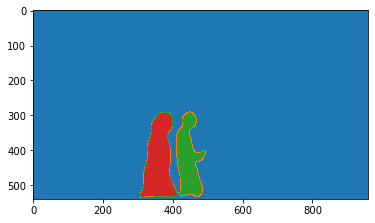

In [38]:
# define a colormap with the matplotlib default colors
plt.imshow(object_maps[230], cmap='tab10', vmax=10)